# Initialization

In [1]:
import os
import torch, pyro, numpy as np 

# from clipppy.globals import register_globals
from clipppy import load_config
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5))

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# register_globals(**globals())

In [10]:
import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *
from channels import split_channels

In [33]:
from PIL import Image
import matplotlib.image as mpimg
import skimage.io as io

### Load config

In [76]:
SYSTEM_NAME = "hoags_object"

os.makedirs(SYSTEM_NAME, exist_ok=True)
BASEDIR = os.path.join(SYSTEM_NAME)
os.makedirs(BASEDIR, exist_ok=True)

In [77]:
SOURCE_DIR = '../../mock_data/source_jpgs'
source_name = f'{SYSTEM_NAME}.jpg'

config = load_config('config-Copy1.yaml', base_dir=SOURCE_DIR,
                     source_name=source_name)

model = config.umodel
# guide = config.guide

MASK = config.kwargs['defs']['mask']
NOISE = model.stochastic_specs['sigma_stat']
PARAMS = YAML().load(open('../paper-source/params.yaml'))[SYSTEM_NAME]

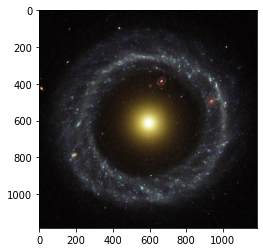

In [78]:
image_path = os.path.join(SOURCE_DIR, source_name)
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

In [80]:
(height, width, n_channels) = img.shape

In [96]:
img

array([[[14,  8, 22],
        [ 7,  1, 13],
        [ 7,  0, 12],
        ...,
        [ 5,  4,  0],
        [10,  9,  5],
        [11,  4,  0]],

       [[17, 11, 25],
        [10,  4, 16],
        [ 7,  1, 11],
        ...,
        [ 5,  5,  3],
        [12, 12, 10],
        [19, 14,  8]],

       [[11,  5, 17],
        [10,  4, 16],
        [ 7,  1, 11],
        ...,
        [ 2,  2,  2],
        [ 9,  9,  9],
        [13,  8,  4]],

       ...,

       [[ 9,  7, 10],
        [ 6,  4,  7],
        [12, 10, 11],
        ...,
        [ 2,  1,  0],
        [ 2,  1,  0],
        [ 6,  5,  3]],

       [[ 8,  6,  9],
        [ 6,  4,  5],
        [15, 13, 14],
        ...,
        [ 4,  0,  0],
        [ 4,  0,  0],
        [ 6,  0,  0]],

       [[10,  8, 13],
        [ 9,  7, 12],
        [16, 11, 17],
        ...,
        [ 3,  1,  6],
        [ 2,  0,  5],
        [ 5,  1,  0]]], dtype=uint8)

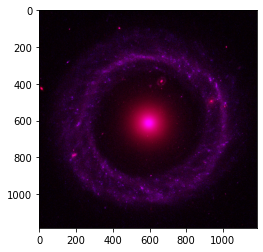

In [104]:
img_col = img.copy()


img_col[:,:,1] = 0

# print(img_col)

plt.imshow(img_col)

RGB figure, let's continue.


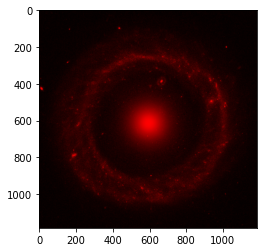

In [92]:
img_col = img.copy()

if n_channels == 3:
    print("RGB figure, let's continue.")
else:
    print('No RGB figure, stop this script!')
    
for h in range(height):
    for w in range(width):
        r,g,b = img_col[h, w]
        img_col[h, w] = r,0,0
        
plt.imshow(img_col)

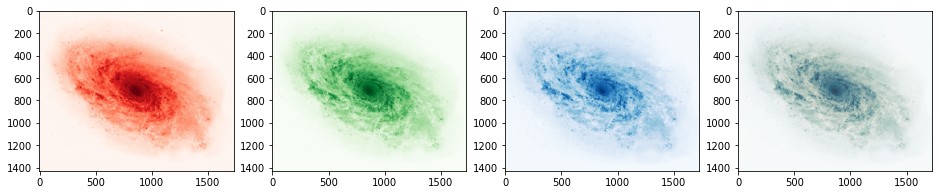

In [72]:
imgs = [img[:,:,0], img[:,:,1], img[:,:,2]]
cols = ['Reds', 'Greens', 'Blues']

fig, axs = plt.subplots(1, 4, figsize = (16,4))
for ax, col, i in zip(axs, cols, imgs):
    ax.imshow(i, cmap = col)
    axs[3].imshow(i, cmap = col, alpha = 0.5)
fig.show()

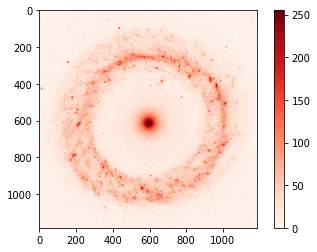

In [48]:
im = plt.imshow( img[:,:,2], cmap = 'Reds')
plt.colorbar(im)

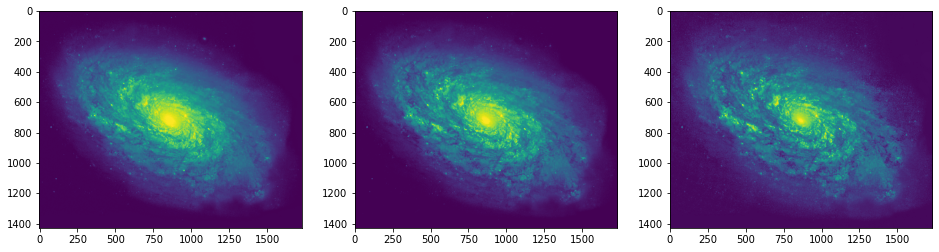

In [65]:
plot_imshow([img[:,:,0], img[:,:,1], img[:,:,2]])

In [53]:
img[:,:,0]

array([[14,  7,  7, ...,  5, 10, 11],
       [17, 10,  7, ...,  5, 12, 19],
       [11, 10,  7, ...,  2,  9, 13],
       ...,
       [ 9,  6, 12, ...,  2,  2,  6],
       [ 8,  6, 15, ...,  4,  4,  6],
       [10,  9, 16, ...,  3,  2,  5]], dtype=uint8)

config.conditioning
config.guide

most importnat:
config.model (never use)
config.umodel: not conditioned on the data

----

# Generate mock data

#### Utilities

creates a mask for the observations

In [4]:
from skimage.transform import downscale_local_mean
from scipy.ndimage import filters
from pyrofit.lensing.utils import Converter

def get_mask(img, sigma=1., th=1.):
    """
    Generate mask
    """
    smooth = filters.gaussian_filter(img.numpy(), sigma=sigma)
    return smooth > th

#### Set image as source

take the image and set the image as a srouce of the model
sources in the config.yaml will be filled

In [5]:
imgsrc = config.kwargs['defs']['imagesrc']
model.sources = {'image': imgsrc}

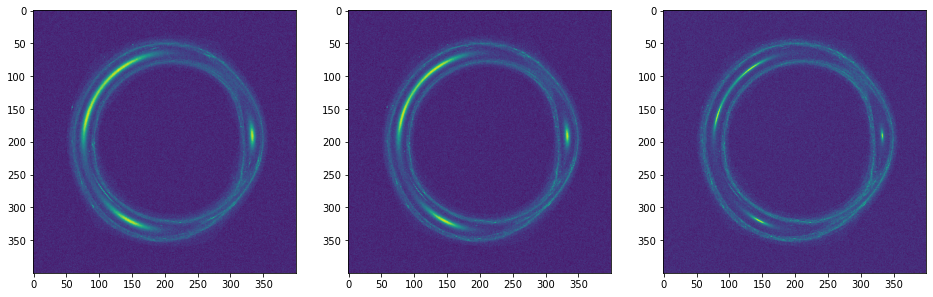

In [15]:
plot_imshow(model())

#### True parameters for generating mock data

In [6]:
PARAMS['truth']

ordereddict([('ext/gamma_1', -0.0227), ('ext/gamma_2', 0.0047), ('main/phi', 1.742), ('main/q', 0.2753), ('main/r_ein', 1.1847), ('main/slope', 2.2193), ('main/x', -0.0704), ('main/y', -0.0193)])

#### Generate a 10nx x 10ny mock image and downsample it to create a mock image

want to have good resolation 4000x4000 of the mock obseration and then downsample it to 400x400

In [16]:
UPSAMPLE = 10

# Save final grid
X, Y = model.X.clone(), model.Y.clone()

# Evaluate model over finer grid
#model._X, model._Y = get_meshgrid(
#    config.kwargs["defs"]["res"] / UPSAMPLE,
#    config.kwargs["defs"]["nx"] * UPSAMPLE,
#    config.kwargs["defs"]["ny"] * UPSAMPLE
#)
model.coerce_XY(*get_meshgrid(
    config.kwargs["defs"]["res"] / UPSAMPLE,
    config.kwargs["defs"]["nx"] * UPSAMPLE,
    config.kwargs["defs"]["ny"] * UPSAMPLE
))
model.mask = torch.full_like(model.X, True, dtype=bool, device="cuda:0")
model.stochastic_specs['sigma_stat'] *= UPSAMPLE
#model.coerce_XY()

# model.

/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:113: RuntimeWarning: Setting items on StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level.
  warn(f'Setting items on {type(self).__name__} by name is frowned upon'


In [7]:
# Sample from the model
with pyro.poutine.trace() as tracer, pyro.condition(data=PARAMS['truth']):
    OBS = model()
OBSTRACE = tracer.trace

# Downsample observation
# OBS = torch.tensor(downscale_local_mean(OBS, (UPSAMPLE, UPSAMPLE)))

# # Downsample info from trace
# data = dict(trace=OBSTRACE, obs=OBS, **{
#     key: torch.tensor(downscale_local_mean(OBSTRACE.nodes[key]['value'], (UPSAMPLE, UPSAMPLE)))
#     for key in ('mu', 'Xsrc', 'Ysrc')
# })

# # Never use it (never double information)
# full_trace = 'False'
# if not full_trace:
#     # Throw recoverable information out
#     trace_data = {}
#     for k, v in obs_trace.nodes.items():
#         if "_deterministic" in v["infer"] and v["infer"]["_deterministic"]:
#             continue
#         if k == config.umodel.observation_name:
#             continue

#         try:
#             trace_data[k] = v["value"].detach().clone()
#         except:
#             trace_data[k] = v["value"]

#     data["trace_data"] = trace_data
# else:
#     data["trace"] = OBSTRACE

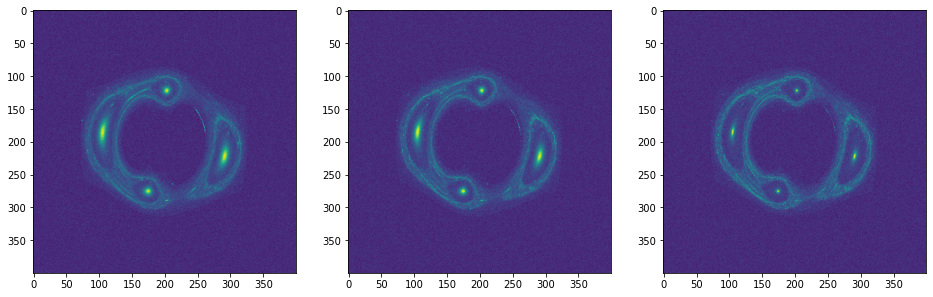

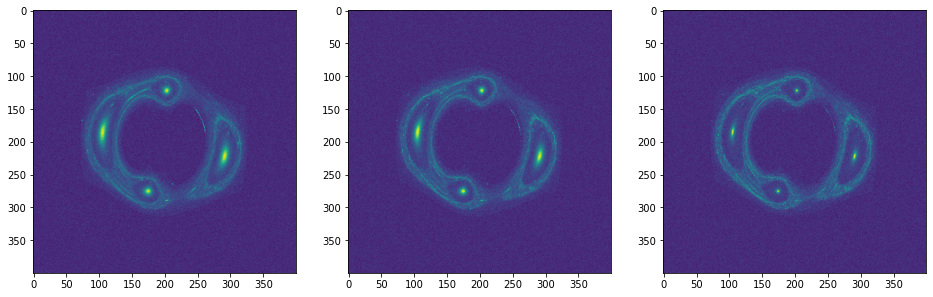

In [20]:
plot_imshow(OBS)
plot_imshow(OBS)

In [9]:
# Restore coarse grid
model.coerce_XY(X, Y)
model.mask = MASK
model.stochastic_specs['sigma_stat'] /= UPSAMPLE

#### Show mock observation

TypeError: Invalid shape (3, 400, 400) for image data

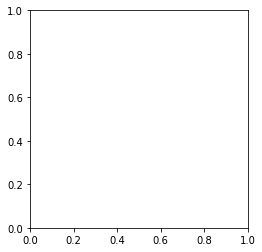

In [8]:
plt.imshow(np.ma.array(data=OBS, mask=False), **imkwargs)
plt.colorbar()

#### Make a mask

41935 unmasked pixels (26.209375381469727% of image)
S/N: 2039.62451171875


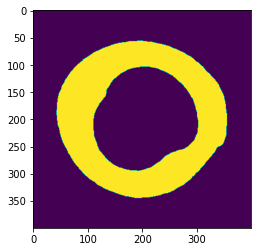

In [11]:
# Generate mask
model.mask = MASK = torch.tensor(get_mask(OBS, sigma=3., th=1.), dtype=bool)
print(f"{MASK.sum()} unmasked pixels ({MASK.sum().float() / MASK.numel() * 100}% of image)")
snr = (MASK * OBS).sum() / (NOISE * np.sqrt(MASK.sum().float()))
print(f"S/N: {snr}")

plt.imshow(MASK)

#### Save everything

In [12]:
torch.save(data, os.path.join(BASEDIR, f"mock_sigma_stat=1.pt"))
np.save(os.path.join(BASEDIR, f"mask.npy"), MASK)